<a href="https://www.kaggle.com/code/therishabhmittal05/birdclef?scriptVersionId=239753088" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd
import librosa 
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm import tqdm
import math
import os
import torch 
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
from torch.amp import autocast, GradScaler
from torchmetrics.classification import BinaryAUROC
from torchsummary import summary

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
train_df = pd.read_csv("/kaggle/input/birdclef-2025/train.csv")
taxo_df = pd.read_csv("/kaggle/input/birdclef-2025/taxonomy.csv")

In [4]:
df = train_df[["primary_label", "filename", "scientific_name"]].copy()
df = df.sort_values(by="primary_label")
prim_class_ = taxo_df.set_index('primary_label')['class_name'].to_dict()
df['label'] = df['primary_label'].astype(str).map(prim_class_) + '_' + df['primary_label'].astype(str)  

In [5]:
df

,primary_label,filename,scientific_name,label
0,1139490,1139490/CSA36385.ogg,Ragoniella pulchella,Insecta_1139490
1,1139490,1139490/CSA36389.ogg,Ragoniella pulchella,Insecta_1139490
2,1192948,1192948/CSA36358.ogg,Oxyprora surinamensis,Insecta_1192948
3,1192948,1192948/CSA36366.ogg,Oxyprora surinamensis,Insecta_1192948
4,1192948,1192948/CSA36373.ogg,Oxyprora surinamensis,Insecta_1192948
...,...,...,...,...
28469,ywcpar,ywcpar/XC382486.ogg,Amazona ochrocephala,Aves_ywcpar
28470,ywcpar,ywcpar/XC401617.ogg,Amazona ochrocephala,Aves_ywcpar
28471,ywcpar,ywcpar/XC407235.ogg,Amazona ochrocephala,Aves_ywcpar
28465,ywcpar,ywcpar/XC375635.ogg,Amazona ochrocephala,Aves_ywcpar


In [8]:
# Important
alllabels = set()
for sample in df.primary_label:
    alllabels.add(sample)

alllabels = sorted(list(alllabels))
n_labels = len(alllabels)

In [9]:
class Config:
    out_dir = "/kaggle/working/mel_spectrograms/"
    in_dir = "/kaggle/input/birdclef-2025/train_audio/"
    fs = 32000

    n_fft = 1024
    hop_length = 256
    n_mels = 64
    fmin = 50
    fmax = 12000

    target_dur = 5
    target_shape = (256, 256)

config = Config()

In [10]:
# import IPython.display as ip
# audio_ = config.in_dir+df.filename[10]
# label = df.label[10]
# print(label)
# ip.Audio(audio_)
# y, sr = librosa.load(config.in_dir + df.filename[10])
# mel_spec_test = librosa.feature.melspectrogram(
#     y=y, 
#     sr=sr,
#     n_fft=config.n_fft,
#     hop_length=config.hop_length,
#     n_mels=config.n_mels,
#     fmin=config.fmin,
#     fmax=config.fmax,
# )
# mel_db = librosa.power_to_db(mel_spec_test, ref=np.max)
# librosa.display.specshow(mel_db)
# plt.show()

In [ ]:
def audio2mel(audio_):
    if np.isnan(audio_).any():
        mean_ = np.nanmean(audio_)
        audio_ = np.nan_to_num(audio_, nan = mean_)

    mel_spec = librosa.feature.melspectrogram(
        y=audio_,
        sr=config.fs,
        n_fft=config.n_fft,
        hop_length=config.hop_length,
        n_mels=config.n_mels,
        fmin=config.fmin,
        fmax=config.fmax,
        power=2.0
    )
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-8)
    return mel_db

In [ ]:
os.makedirs(config.out_dir, exist_ok=True)
for i, row in tqdm(df.iterrows(), total=len(df)):
    audio_, _  = librosa.load(config.in_dir + row.filename, sr=config.fs)
    target_samp = int(config.target_dur * config.fs)

    if len(audio_) < target_samp:
        n_copy = math.ceil(target_samp/len(audio_))
        if n_copy > 1:
            audio_ = np.concatenate([audio_] * n_copy)
    start = max(0, int(len(audio_)/2 - target_samp/2))
    end = min(len(audio_), start+target_samp)

    audio_ = audio_[start:end]
    if len(audio_) < target_samp:
        audio_ = np.pad(audio_, (0, target_samp - len(audio_)), mode='constant')
    mel_spec = audio2mel(audio_)
    if mel_spec.shape != config.target_shape:
        mel_spec = cv.resize(mel_spec, config.target_shape, interpolation=cv.INTER_LINEAR)

    out_path = f"{config.out_dir}{row.label}_{i}.npy"
    np.save(out_path, mel_spec.astype(np.float32))

In [ ]:
 # !ls ./mel_spectrograms | head -2

In [11]:
class BirdClefDs(Dataset):
    def __init__(self, mel_dir, alllabels, n_labels):
        self.mel_dir = mel_dir
        self.files = [f for f in os.listdir(mel_dir) if f.endswith(".npy")]
        self.alllabels = alllabels # sorted labels list, keep it consistent
        self.n_labels = n_labels
    def __len__(self):
        return len(self.files)

    def __getitem__(self, id_):
        filename = self.files[id_]
        filepath = os.path.join(self.mel_dir, filename)

        img = np.load(filepath).astype(np.float32)
        
        if img.ndim == 2:
            img = np.expand_dims(img, axis = 0)
            
        img = torch.from_numpy(img)
        img = img.repeat(3, 1, 1) 
        label_id = self.alllabels.index(filename.split('_')[1])
        label = torch.zeros(self.n_labels, dtype=torch.float32) # one hot encoding
        label[label_id] = 1.0
        return img, label

In [12]:
BirdClef = BirdClefDs(config.out_dir, alllabels, n_labels)

for i, (sample, label) in enumerate(BirdClef):
    print(f"{i}: {sample.size()}, {label}")
    break

0: torch.Size([3, 256, 256]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


In [13]:
train_size = int(0.8 * len(BirdClef))
val_size = len(BirdClef) - train_size
BirdClef_train, BirdClef_val = random_split(BirdClef, [train_size, val_size])

In [14]:
batch_size=8
train_ = DataLoader(BirdClef_train, batch_size=batch_size, shuffle=True, num_workers=4)
val_ = DataLoader(BirdClef_val, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
# for x, y in train_:
#     print(f"{x.shape} : {y.shape}")
#     print(f"{x} : {y}")
#     break

In [15]:
class Model_01(nn.Module):
    def __init__(self, n_labels):
        super().__init__()
        base = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)
        
        self.features = base.features
        self.avg_pool = base.avgpool
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(base.classifier[1].in_features, n_labels)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [16]:
model = Model_01(n_labels).to(device)

In [ ]:
# summary(model, input_size=(3, 256, 256))

In [17]:
lr = 1e-4
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [20]:
# output = model(x.to(device))
# output.shape, y.shape
# auroc = BinaryAUROC()
# auc_score = auroc(output.cpu(), y)

# print(f"AUROC score: {auc_score}")

In [21]:
# print(output[0].shape)

In [22]:
def train(model, train_, criterion, optimizer, scheduler, n_epochs=10):
    losses = []
    auroces = []
    scaler = GradScaler(device=device)
    metric = BinaryAUROC().to(device)
    
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        
        for sample, label in tqdm(train_, total=len(train_)):
            sample = sample.to(device)
            label = label.to(device)
    
            optimizer.zero_grad()
            
            with autocast(device_type=device):
                yhat = model(sample)
                loss = criterion(yhat, label)
                
            scaler.scale(loss).backward() # loss.backward()
            scaler.step(optimizer) # optimizer.step()
            scaler.update()
                        
            running_loss += loss.item() * sample.size(0)
            metric.update(yhat.sigmoid(), label)
        
        auroc = metric.compute().item()
        epoch_loss = running_loss / len(train_.dataset)

        losses.append(epoch_loss)
        auroces.append(auroc)
        metric.reset()
        
        print(f'Epoch {epoch+1}/{n_epochs} - Loss: {epoch_loss:.4f}, ROC: {auroc:.4f}')
        scheduler.step(epoch_loss)
        
    return losses, auroces

losses, auroces = train(model, train_, criterion, optimizer, scheduler)

100%|██████████| 2857/2857 [07:37<00:00,  6.24it/s]


Epoch 1/10 - Loss: 0.0303, ROC: 0.8203


100%|██████████| 2857/2857 [07:42<00:00,  6.17it/s]


Epoch 2/10 - Loss: 0.0203, ROC: 0.9158


100%|██████████| 2857/2857 [07:41<00:00,  6.19it/s]


Epoch 3/10 - Loss: 0.0188, ROC: 0.9314


100%|██████████| 2857/2857 [07:38<00:00,  6.23it/s]


Epoch 4/10 - Loss: 0.0182, ROC: 0.9363


100%|██████████| 2857/2857 [07:38<00:00,  6.23it/s]


Epoch 5/10 - Loss: 0.0179, ROC: 0.9395


100%|██████████| 2857/2857 [07:34<00:00,  6.28it/s]


Epoch 6/10 - Loss: 0.0179, ROC: 0.9414


100%|██████████| 2857/2857 [07:34<00:00,  6.29it/s]


Epoch 7/10 - Loss: 0.0181, ROC: 0.9402


100%|██████████| 2857/2857 [07:33<00:00,  6.30it/s]


Epoch 8/10 - Loss: 0.0185, ROC: 0.9383


100%|██████████| 2857/2857 [07:32<00:00,  6.31it/s]


Epoch 9/10 - Loss: 0.0192, ROC: 0.9362


100%|██████████| 2857/2857 [07:32<00:00,  6.32it/s]

Epoch 10/10 - Loss: 0.0200, ROC: 0.9320


In [23]:
print(losses, auroces)

[0.030284612761996028, 0.02033509025953814, 0.018827312289419713, 0.018216691876414656, 0.01789172760538082, 0.017885327333221943, 0.01808116596330204, 0.018523236489508935, 0.01922086933593897, 0.019951520338579526] [0.8203110098838806, 0.9158176183700562, 0.9314115643501282, 0.9363361597061157, 0.939468502998352, 0.941399097442627, 0.9401917457580566, 0.938264012336731, 0.9362142086029053, 0.9319866895675659]


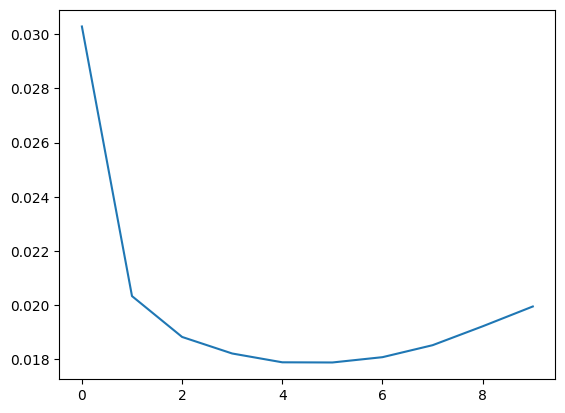

In [24]:
plt.plot(losses)
plt.show()

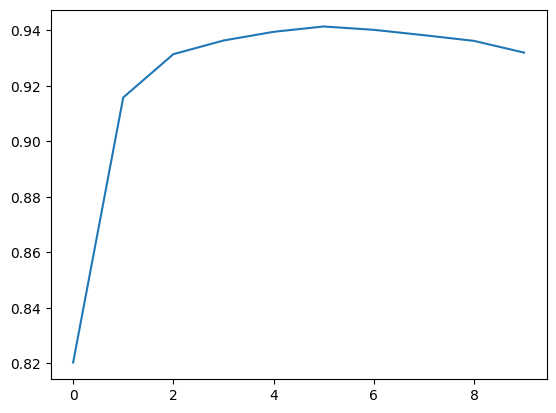

In [25]:
plt.plot(auroces)
plt.show()

In [26]:
def evaluate(model, val_, criterion):
    model.eval()
    val_loss = 0.0
    metric = BinaryAUROC().to(device)
    with torch.no_grad():
        for sample, label in tqdm(val_):
            sample = sample.to(device)
            label = label.to(device) 
            
            with autocast(device_type=device):
                y_pred = model(sample)
                loss = criterion(y_pred.sigmoid(), label)
                
            metric.update(y_pred.sigmoid(), label)    
            val_loss += loss.item() *  sample.size(0)
            
    auroc = metric.compute().item()     
    val_loss /= len(val_.dataset)
    return val_loss, auroc

In [27]:
val_loss, auroc = evaluate(model, val_, criterion)
print(f"Validation Loss: {val_loss:.4f} | ROC: {auroc:.4f}")

100%|██████████| 715/715 [00:33<00:00, 21.43it/s]

Validation Loss: 0.6955 | ROC: 0.9383


In [28]:
torch.save(model.state_dict(), "/kaggle/working/BirdClefmodel01.pth")